In [283]:
##House Prices: Advanced Regression Techniques Test 
##Author: Nok Chan 
##Last modified: 8/13/2017

![Kaggle House Price Competition](HousePrice.png)

![Rank](rank1.png)

![Total Participant](rank2.png)

In [368]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
#pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import os
%matplotlib inline 
import pylab 
import scipy.stats as stats
plt.style.use('ggplot')
#This line force the graph print out in this jupyter Notebook



In [285]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [286]:

testset = pd.read_csv('test.csv')
trainset = pd.read_csv('train.csv')

In [287]:
trainset.isnull().sum()
## Some features have almost all null in every rows, so I will remove null> 1000 for cleaning the features a little bit.


Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [288]:
features = trainset.columns.values
remove_features = trainset.columns[trainset.isnull().sum()>1000]


In [289]:
print(testset.shape)
print(trainset.shape)

(1459, 80)
(1460, 81)


In [290]:
trainset = trainset.drop(remove_features,1)
trainset = trainset.drop('Id', 1)


In [291]:
testset = testset.drop(remove_features,1)
testset_id = testset['Id']
testset = testset.drop('Id', 1)

In [292]:
remove_features

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [293]:
print(testset.shape)
print(trainset.shape)

(1459, 75)
(1460, 76)


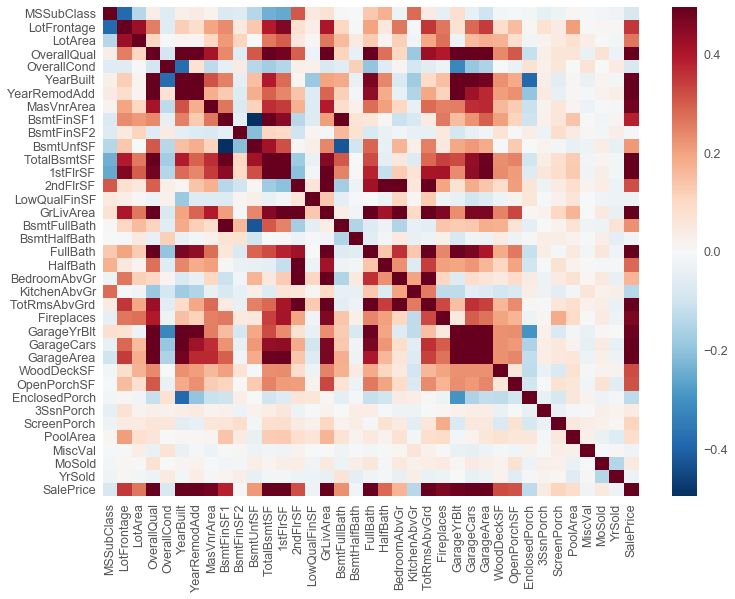

In [294]:
## For now, i will start with the numerical variable and ignore the categorial variables for a while
## Start with correlation always give you some insights about how different factor related.
## Since the number of variables is large, it's not easy to visualize with table, a matrix could help us on this.
## Seaborn library-
train_cor = trainset.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(train_cor,vmax=0.1)

In [295]:
## From the heatmap we can see some variable has correlation very close to 0.8
## Grage YrBlt,GarageCars,Garage Area are strongly correlated, we don't want this collinearity as Area of Garage 
##is limiting factor of how many car u can park.

## TotalBsmtSF and ,1stFlrSF  is also highly correlated, see the metadata.
##     1stFlrSF: First Floor square feet
## TotalBsmtSF: Total square feet of basement area

## YearBLT is also highly correlated to GarageYearBLT
## OverallQuality has a strong correlation with Sales Price too, this is good as this is a useful indicator for predicting 
## sales price which is our ultimate goal.



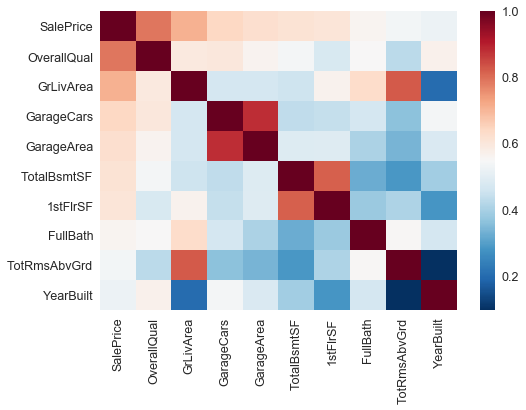

In [296]:
## To decide which factor we should keep, I will keep the factor that are more correlated to sales price as I think this
## will help the performence of the model.

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = train_cor.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(trainset[cols].values.T)
sns.set(font_scale=1.25)


hm = sns.heatmap(cm,cmap="RdBu_r", yticklabels=cols.values, xticklabels=cols.values)

## The order of the features is already sorted in descending order.




In [297]:
## GarageCars has a higher correlation, so Garage Area and GarageYearBlt will be dropped.
## TotalBsmtSF has a higher correlation with 1stFlrSF, so it will be dropped as well.
trainset = trainset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)
testset = testset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)

In [298]:
print(trainset.shape)
print(testset.shape)
## Ok , 3 mores columns dropped

(1460, 73)
(1459, 72)


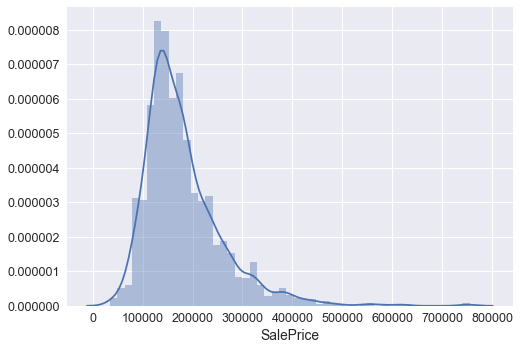

In [299]:
## So some more EPA about our target variable -- Sales Price

sns.distplot(trainset['SalePrice'])


## The data looks quite good, money is always appear in a skewed distribution in normal scale, we can normalized it in a log scale.


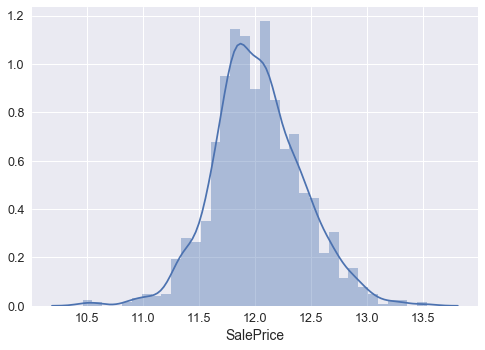

In [300]:
sns.distplot(np.log(trainset['SalePrice']))

## Voila, it is very close to normal distrubtion.
## Therefore, it is good to apply log transformation to SalePrice variable as regression usually need a normal distribution error assumption

trainset['SalePrice'] =np.log(trainset['SalePrice'])

In [301]:
train_labels = trainset['SalePrice']
trainset = trainset.drop('SalePrice',1)


In [302]:
from sklearn.model_selection import train_test_split
testset_index = range(len(trainset),len(trainset) + len(testset))

trainset_index, validset_index = train_test_split(range(len(trainset)),
                                    random_state = 42 , test_size = 0.3)


In [303]:
print(len(trainset_index), len(validset_index))

1022 438


In [304]:
masterset = pd.concat([trainset,testset], axis = 0)

In [305]:
masterset.shape

(2919, 72)

In [306]:
masterset_backup = masterset
# Getting Dummies from all other categorical vars
for col in masterset.dtypes[masterset.dtypes == 'object'].index:
    for_dummy = masterset.pop(col)
    masterset = pd.concat([masterset, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [307]:
masterset.shape

(2919, 272)

In [308]:
train_labels_full = train_labels
train_features_full = masterset.iloc[range(len(trainset))]

In [309]:
train_features = masterset.iloc[trainset_index] 
test_features = masterset.iloc[testset_index]
valid_features = masterset.iloc[validset_index]

## Take a copy of it will be a reference of train_labels
valid_labels = train_labels[validset_index].copy() 

train_labels = train_labels[trainset_index]

In [310]:
print(train_features.shape)
print(test_features.shape)

(1022, 272)
(1459, 272)


In [375]:
from sklearn.metrics import mean_squared_error

def plot(actual, predict, title):
    plt.figure(figsize=(8, 4))
    plt.scatter(actual, predict, s=20, c='steelblue')
    plt.title('Predicted vs. Actual '+ title)
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')

    plt.plot([min(actual), max(actual)], [min(actual), max(actual)],c ='red')
    plt.tight_layout()
    
def error_plot(actual, predict, title):
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1,2,1)
    
    plt.scatter(range(1,len(actual) + 1),actual-predict, s=20)
    plt.title('Sales Price Error '+ title)    
    plt.ylabel('Sales Price Error(log Actual - log Predict)')
    ax2 = fig.add_subplot(1,2,2)
    stats.probplot(actual - predict, dist="norm", plot=pylab)
    pylab.show()

    
    
    
def summary(model,train_features, train_labels, valid_features, valid_labels):
    ## Because I have done log transform to the labels already, so we use mean squared error here
    ## is actually mean suqared log error
    train_predicts = model.predict(train_features)
    valid_predicts = model.predict(valid_features)
    print('Cross Val (Train set)', np.sqrt(-cross_val_score(model, train_features, train_labels,
                scoring = 'neg_mean_squared_error')))
    print('Cross Val (valid set)',np.sqrt(-cross_val_score(model, valid_features, valid_labels,
                      scoring = 'neg_mean_squared_error')))
    print('Accuracy Val(Train set)', model.score(train_features, train_labels))
    print('Accuracy Val (Valid set)',model.score(valid_features, valid_labels))
    print('Roo tMean Squarted Log Error (Train set): ', mean_squared_error(train_labels,
                                                    train_predicts)**0.5)
    print('Root Mean Squarted Log Error (Valid set): ', mean_squared_error(train_labels,
                                                    train_predicts)**0.5)
    
    ## Graph Actual vs Predict
    plot(train_labels, train_predicts, 'Training Set')
    plot(valid_labels, valid_predicts, 'Validating Set')
    
    ## Error Plot
    error_plot(train_labels, train_predicts, 'Training Set')
    error_plot(valid_labels, valid_predicts, 'Validating Set')
    
   
   

## Gradient Boosting

In [313]:
## Model
GBest = ensemble.GradientBoostingRegressor( max_features='sqrt',
                                           min_samples_leaf=15, min_samples_split=10,
                                           loss='huber',
                                           random_state = 42)
PipeGB = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('boost', GBest)
    ])
# estimator parameters
kfeatures = [32,64,128,256]
components = [4,8,16,32]
estimators = [256,512,1024]
learnrate = [0.001,0.01,0.1,1]
depth = [3,6,9]

param_grid_GB={'selection__k': kfeatures,
              'pca__n_components': components,
              'imp__strategy': ['mean','median'],
                'imp__missing_values': ['NaN'],
              'boost__n_estimators': estimators,
              'boost__learning_rate':  learnrate,
            'boost__max_depth' : depth
               }

In [314]:
# set model parameters to grid search object
gridCV_GB = RandomizedSearchCV(estimator = PipeGB, 
                             param_distributions = param_grid_GB,
                             n_iter = 5,
                             scoring = 'neg_mean_squared_log_error',
                             cv = 5)

        
# train the model
gridCV_GB.fit(train_features, train_labels)

print(gridCV_GB.best_params_)


C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 95  98  99 121 134 151 169 183 201 210 217 259 264] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 48  49  95  97  98  99 118 119 121 122 134 151 169 183 201 204 217 228
 259 261] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\uni

C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 59  82  90  95  96  98  99 121 128 134 143 151 169 183 201 206 217 259] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 95  98  99 121 123 134 137 151 166 169 183 201 217 247 259 268] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\

{'selection__k': 32, 'imp__missing_values': 'NaN', 'boost__n_estimators': 256, 'imp__strategy': 'median', 'pca__n_components': 32, 'boost__learning_rate': 0.01, 'boost__max_depth': 9}


In [315]:
gridCV_GB.best_params_

{'boost__learning_rate': 0.01,
 'boost__max_depth': 9,
 'boost__n_estimators': 256,
 'imp__missing_values': 'NaN',
 'imp__strategy': 'median',
 'pca__n_components': 32,
 'selection__k': 32}

In [316]:
##import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_GB.pkl', 'wb') as source:    
  s = pickle.dump(gridCV_GB.best_estimator_, source)

In [317]:
with open('model_GB.pkl','rb') as load:
    model_GB = pickle.load(load)

C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 38  39  48  49  92  95  97  98  99 118 121 122 134 151 169 183 201 210
 217 228 259 264] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 53  95  96  98  99 119 121 128 129 131 134 143 144 146 151 169 183 201
 204 206 217 244 249 259 261 264 268] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Co

Cross Val (Train set) [ 0.20952756  0.20533802  0.17881857]


C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 33  38  39  42  48  49  53  58  59  60  90  91  92  95  96  97  98  99
 106 108 109 115 118 119 121 122 123 125 126 127 128 129 131 134 137 142
 144 146 151 153 158 163 166 169 175 176 183 195 197 201 202 203 204 205
 206 210 216 217 224 227 228 239 244 247 249 252 258 259 260 264 267 268
 269] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.

Cross Val (valid set) [ 0.43089882  0.41362684  0.32091168]
Accuracy Val(Train set) 0.891618858273
Accuracy Val (Valid set) 0.77531680688
Roo tMean Squarted Log Error (Train set):  0.129613614332
Root Mean Squarted Log Error (Valid set):  0.129613614332


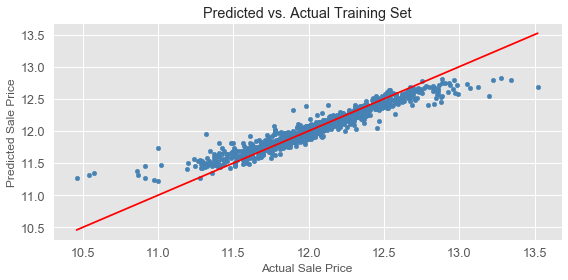

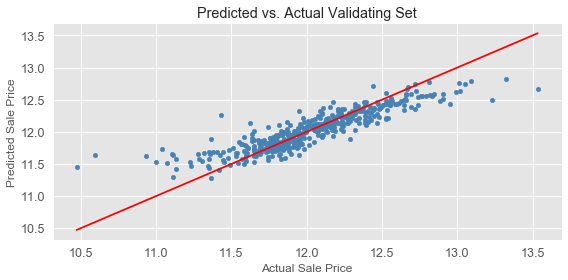

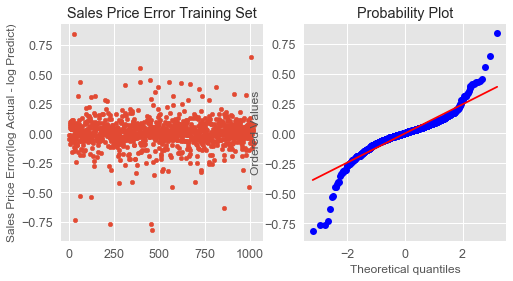

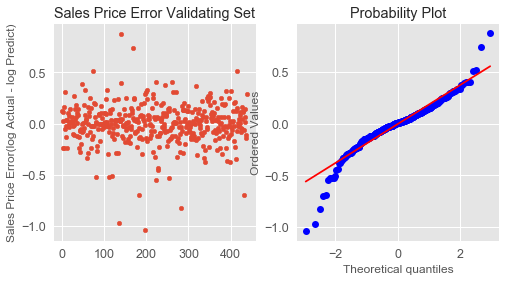

In [376]:
summary(model_GB,train_features, train_labels, valid_features, valid_labels)

In [319]:
### Validation

In [320]:
result_GB = model_GB.predict(test_features)

In [321]:
## Output result, match the require format
result_pd= pd.DataFrame(np.array(list(zip(testset_index,result_GB))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd.Id = result_pd.Id.astype('int') + 1 ## Id = index + 1
result_pd['SalePrice'] = result_pd['SalePrice'].apply(lambda x: np.e**(x))

In [322]:
result_pd[0:5]

,Id,SalePrice
0,1461,125905.199946
1,1462,145849.179589
2,1463,176094.125022
3,1464,183427.469691
4,1465,212241.407324


In [323]:
pd.DataFrame(result_pd).to_csv('result.csv',index = False)

## Random Forest

In [324]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
## Model
RF = RandomForestRegressor( max_features='sqrt'
                            ,n_jobs = 4, random_state = 42 )
PipeRF = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
          ('pca', PCA()),
        ('RF', RF)
    ])
# estimator parameters

components = [8,16,32,64]

minsamplessplit = [10,15,30]

minsamplessleaf = [2,4,6,8]

param_grid_RF={
              'pca__n_components': components,
              'imp__strategy': ['mean','median'],                         
            'RF__min_samples_leaf' : minsamplessleaf,
            'RF__min_samples_split' : minsamplessplit
               }

In [325]:
# set model parameters to grid search object
gridCV_RF = GridSearchCV(estimator = PipeRF, 
                             param_grid = param_grid_RF,
                            
                             scoring = 'neg_mean_squared_error',
                             cv = 5)

        
# train the model
gridCV_RF.fit(train_features, train_labels)


print(gridCV_RF.best_params_)


{'RF__min_samples_leaf': 2, 'imp__strategy': 'median', 'RF__min_samples_split': 10, 'pca__n_components': 16}


Cross Val (Train set) [ 0.22661866  0.25239669  0.20774934]
Cross Val (valid set) [ 0.27759752  0.26463722  0.22848   ]
Accuracy Val(Train set) 0.873739939295
Accuracy Val (Valid set) 0.709722560987
Roo tMean Squarted Log Error (Train set):  0.139896470392
Root Mean Squarted Log Error (Valid set):  0.139896470392


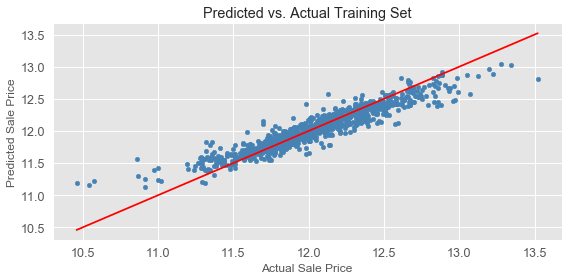

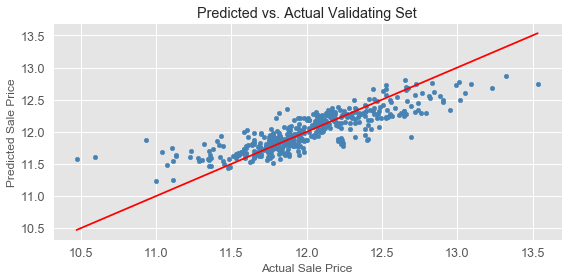

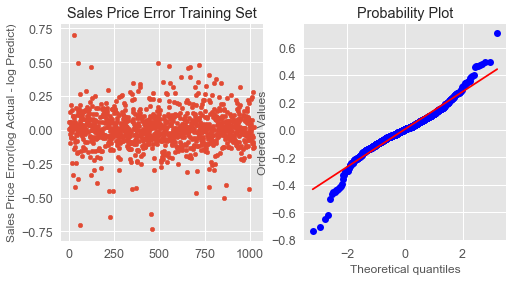

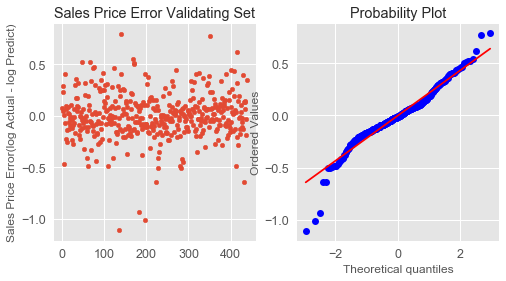

In [377]:
summary(model_RF,train_features, train_labels, valid_features, valid_labels)

In [327]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_RF.pkl', 'wb') as source:    
    s = pickle.dump(gridCV_RF.best_estimator_, source)
with open('model_RF.pkl','rb') as load:
    model_RF = pickle.load(load)

In [328]:
from sklearn.model_selection import cross_val_score
cross_val_score(gridCV_RF.best_estimator_, train_features, train_labels,
                cv = 5, scoring = 'neg_mean_squared_log_error')

array([-0.00031051, -0.00032116, -0.00036183, -0.00031819, -0.00023431])

In [329]:
## Output result, match the require format
result_RF = model_RF.predict(test_features)
result_pd_RF= pd.DataFrame(np.array(list(zip(testset_index,result_RF))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd_RF.Id = result_pd_RF.Id.astype('int') + 1 ## Id = index + 1
result_pd_RF['SalePrice'] = result_pd_RF['SalePrice'].apply(lambda x: np.e**(x))

In [330]:
pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)

## Elastic Net

In [331]:
from sklearn import linear_model

In [332]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
## Model
EN = linear_model.ElasticNetCV(  random_state = 42 )
PipeEN = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('EN', EN)
    ])
# estimator parameters

alphas = [50]
l1_ratio = [0.0001, 0.001, 0.01, 0.1,0.5,1]

param_grid_EN = {             
              'imp__strategy': ['mean','median'],                         
            'EN__n_alphas' :alphas, 
            'EN__l1_ratio' : l1_ratio
               }

In [333]:
# set model parameters to grid search object
gridCV_EN = GridSearchCV(estimator = PipeEN, 
                             param_grid = param_grid_EN,                            
                             scoring = 'neg_mean_squared_error',
                             cv = 5)

        
# train the model
gridCV_EN.fit(train_features, train_labels)


print(gridCV_EN.best_params_)
print(gridCV_EN.cv_results_)

{'imp__strategy': 'mean', 'EN__n_alphas': 50, 'EN__l1_ratio': 0.01}
{'split1_train_score': array([-0.06306009, -0.06305982, -0.02456468, -0.02456459, -0.01080638,
       -0.01080683, -0.00842734, -0.00842742, -0.00864032, -0.00864016,
       -0.00907328, -0.00907328]), 'std_train_score': array([ 0.00186397,  0.0018639 ,  0.00132141,  0.00132145,  0.00147295,
        0.00147279,  0.00228427,  0.00228424,  0.00219104,  0.0021911 ,
        0.00193692,  0.00193692]), 'param_EN__l1_ratio': masked_array(data = [0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1 0.5 0.5 1 1],
             mask = [False False False False False False False False False False False False],
       fill_value = ?)
, 'split2_test_score': array([-0.0849899 , -0.08498963, -0.0386426 , -0.0386412 , -0.02373169,
       -0.0237323 , -0.0229397 , -0.0229397 , -0.02232838, -0.02232838,
       -0.02175976, -0.02175976]), 'split3_test_score': array([-0.06272781, -0.0627278 , -0.03259506, -0.03259545, -0.01859975,
       -0.01860027

In [334]:
gridCV_EN.get_params().keys()

dict_keys(['estimator__EN__random_state', 'estimator__memory', 'scoring', 'estimator__EN__verbose', 'estimator__std', 'estimator__EN__cv', 'n_jobs', 'param_grid', 'error_score', 'estimator__EN__l1_ratio', 'iid', 'estimator__EN__eps', 'estimator__EN__selection', 'estimator__EN__normalize', 'estimator__EN__precompute', 'return_train_score', 'estimator__std__copy', 'estimator__EN__n_alphas', 'estimator__imp__strategy', 'estimator__imp__missing_values', 'estimator__imp', 'estimator', 'cv', 'estimator__imp__axis', 'estimator__EN__max_iter', 'estimator__steps', 'estimator__std__feature_range', 'estimator__EN__copy_X', 'estimator__EN__fit_intercept', 'estimator__imp__copy', 'estimator__EN', 'pre_dispatch', 'estimator__EN__tol', 'estimator__EN__positive', 'fit_params', 'estimator__imp__verbose', 'refit', 'estimator__EN__n_jobs', 'estimator__EN__alphas', 'verbose'])

In [335]:
print(valid_features.shape)
print(valid_labels.shape)
print(train_features.shape)
print(train_labels.shape)


(438, 272)
(438,)
(1022, 272)
(1022,)


In [378]:
import pickle
model_EN = gridCV_EN.best_estimator_
# Save the model if rerun above cell for searching hyperparameters
with open('model_EN.pkl', 'wb') as source:    
    s = pickle.dump(gridCV_EN.best_estimator_, source)
with open('model_EN.pkl','rb') as load:
    model_EN = pickle.load(load)

Cross Val (Train set) [ 0.14668422  0.17370085  0.12778062]
Cross Val (valid set) [ 0.13544255  0.16036231  0.14941215]
Accuracy Val(Train set) 0.904296275493
Accuracy Val (Valid set) 0.877506212926
Roo tMean Squarted Log Error (Train set):  0.121797445618
Root Mean Squarted Log Error (Valid set):  0.121797445618


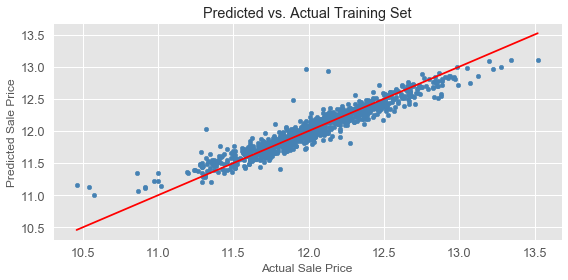

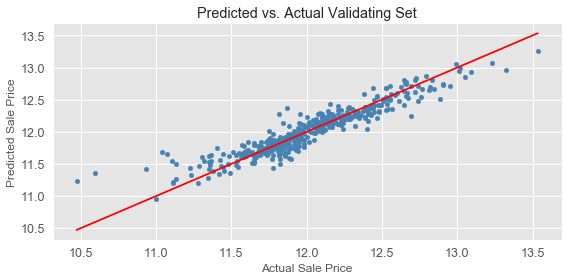

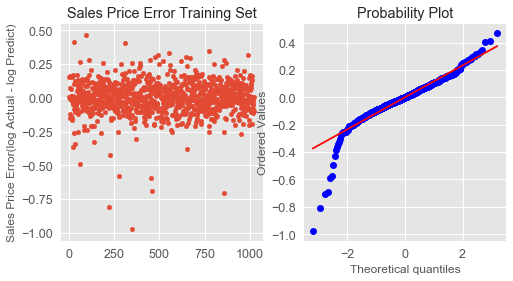

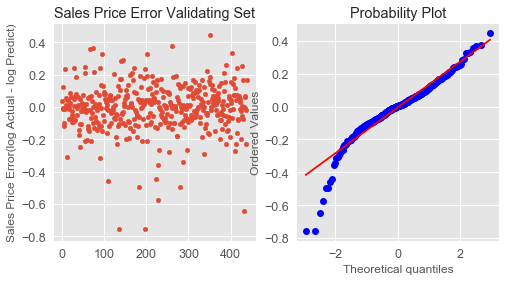

In [379]:
summary(model_EN,train_features, train_labels, valid_features, valid_labels)

In [338]:
## Output result, match the require format
result_EN = model_EN.predict(test_features)
result_pd_EN= pd.DataFrame(np.array(list(zip(testset_index,result_EN))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd_EN.Id = result_pd_EN.Id.astype('int') + 1 ## Id = index + 1
result_pd_EN['SalePrice'] = result_pd_EN['SalePrice'].apply(lambda x: np.e**(x))

In [339]:
pd.DataFrame(result_pd_EN).to_csv('resultEN.csv',index = False)

## Fit model with entire training set and run result

## ElasticNet Final

In [340]:
PipeEN_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('EN', model_EN)
    ])

In [341]:
PipeEN_final.fit(train_features_full, train_labels_full)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('EN', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', MinMaxScaler(c...ve=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0))]))])

In [342]:
## Output result, match the require format
result_EN = PipeEN_final.predict(test_features)
result_pd_EN= pd.DataFrame(np.array(list(zip(testset_index,result_EN))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd_EN.Id = result_pd_EN.Id.astype('int') + 1 ## Id = index + 1
result_pd_EN['SalePrice'] = result_pd_EN['SalePrice'].apply(lambda x: np.e**(x))

In [343]:
pd.DataFrame(result_pd_EN).to_csv('resultEN.csv',index = False)